In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import json
import sys
import os
import kad.visualization.visualization as visualization
import kad.kad_utils.kad_utils as kad_utils
import kad.models_evaluation.models_evaluator as models_evaluator

sys.path.insert(1, '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector')
print(sys.path)

import kad.ts_analyzer.ts_analyzer as ts_analyzer
from kad.model import i_model
from kad.model import sarima_model
from sklearn.model_selection import train_test_split

kad_utils.customize_matplotlib()

['/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/notebooks', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/IPython/extensions', '/home/maciek/.ipython']


In [2]:
SARIMA_KEY: str = "SARIMA"
AUTOENCODER_KEY: str = "autoencoder"
ACC_KEY: str = "accuracy"
PREC_KEY: str = "precision"
RECALL_KEY: str = "recall"

In [3]:
def evaluate_sarima(p_preprocessed_df: pd.DataFrame):
    values_df = p_preprocessed_df[["value"]]
    tsa = ts_analyzer.TsAnalyzer(values_df)
    dominant_freq = tsa.calculate_dominant_frequency()

    model: i_model.IModel = sarima_model.SarimaModel(order=(0, 0, 0), seasonal_order=(1, 0, 1, dominant_freq))

    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 18
    for i in range(0, len(test_df), samples_to_predict):
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    evaluation_df = results_df.copy()
    evaluation_df["gt_is_anomaly"] = p_preprocessed_df["gt_is_anomaly"]
    visualization.visualize(evaluation_df, metric_name="value")

    evaluation_df = evaluation_df.loc[test_df.index & evaluation_df.index]
    evaluator = models_evaluator.ModelsEvaluator(df=evaluation_df)

    print("Accuracy: ", evaluator.get_accuracy())
    print("Avg precision: ", evaluator.get_average_precision())
    print("Recall: ", evaluator.get_recall_score())

    return {ACC_KEY: evaluator.get_accuracy(),
            PREC_KEY: evaluator.get_average_precision(),
            RECALL_KEY: evaluator.get_recall_score()}

art_daily_flatmiddle.csv
                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                   35
Model:             SARIMAX(1, 0, [1], 24)   Log Likelihood                   9.686
Date:                    Sat, 15 May 2021   AIC                            -13.372
Time:                            17:56:25   BIC                             -8.706
Sample:                                 0   HQIC                           -11.761
                                     - 35                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.9998      0.000   7047.380      0.000       1.000       1.000
ma.S.L24       9.9127      2.532      3.915      0.000       4.950      14

<ipython-input-3-054bc895fcbe>:20: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  evaluation_df = evaluation_df.loc[test_df.index & evaluation_df.index]


Accuracy:  0.95
Avg precision:  0.5
Recall:  0.82
art_daily_jumpsdown.csv
                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                   35
Model:             SARIMAX(1, 0, [1], 24)   Log Likelihood                   3.004
Date:                    Sat, 15 May 2021   AIC                             -0.008
Time:                            17:56:27   BIC                              4.658
Sample:                                 0   HQIC                             1.603
                                     - 35                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.9997      0.000   4670.208      0.000       0.999       1.000
ma.S.L24       1.2042    

<ipython-input-3-054bc895fcbe>:20: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  evaluation_df = evaluation_df.loc[test_df.index & evaluation_df.index]


Accuracy:  0.88
Avg precision:  0.38
Recall:  0.55
art_daily_nojump.csv
                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                   35
Model:             SARIMAX(1, 0, [1], 24)   Log Likelihood                   5.264
Date:                    Sat, 15 May 2021   AIC                             -4.528
Time:                            17:56:29   BIC                              0.138
Sample:                                 0   HQIC                            -2.917
                                     - 35                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.9997      0.000   3758.298      0.000       0.999       1.000
ma.S.L24      16.6276      

<ipython-input-3-054bc895fcbe>:20: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  evaluation_df = evaluation_df.loc[test_df.index & evaluation_df.index]


Accuracy:  0.7
Avg precision:  0.31
Recall:  0.55
art_daily_jumpsup.csv
                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                   35
Model:             SARIMAX(1, 0, [1], 24)   Log Likelihood                   8.940
Date:                    Sat, 15 May 2021   AIC                            -11.880
Time:                            17:56:32   BIC                             -7.214
Sample:                                 0   HQIC                           -10.269
                                     - 35                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.9999    8.6e-05   1.16e+04      0.000       1.000       1.000
ma.S.L24      49.1470   1.6

<ipython-input-3-054bc895fcbe>:20: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  evaluation_df = evaluation_df.loc[test_df.index & evaluation_df.index]


Accuracy:  0.87
Avg precision:  0.39
Recall:  1.0


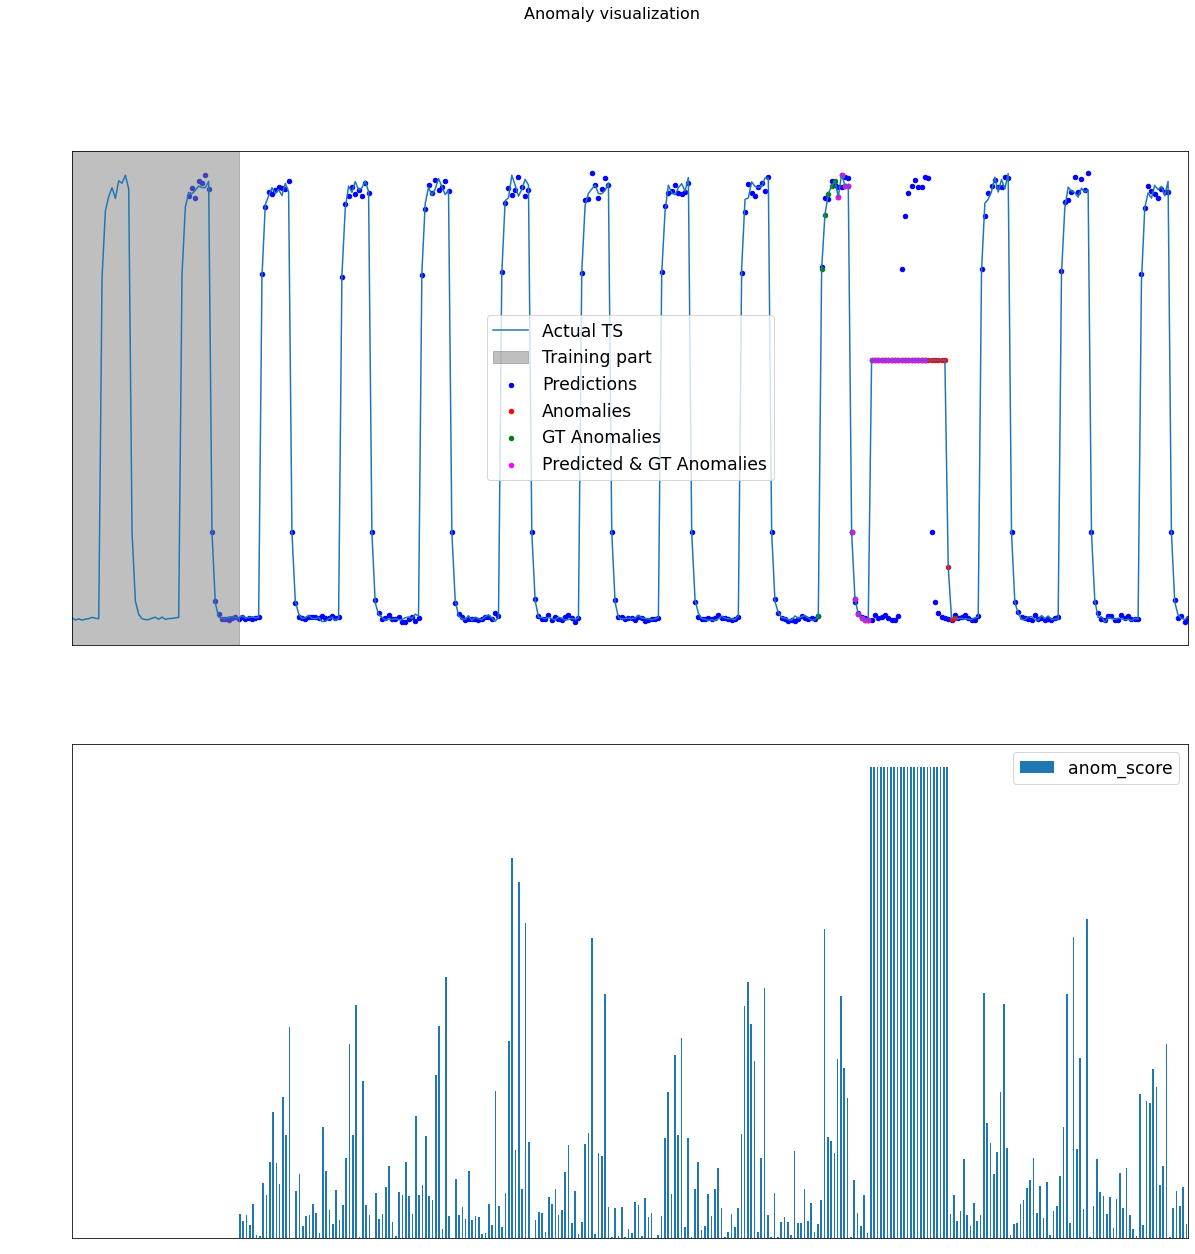

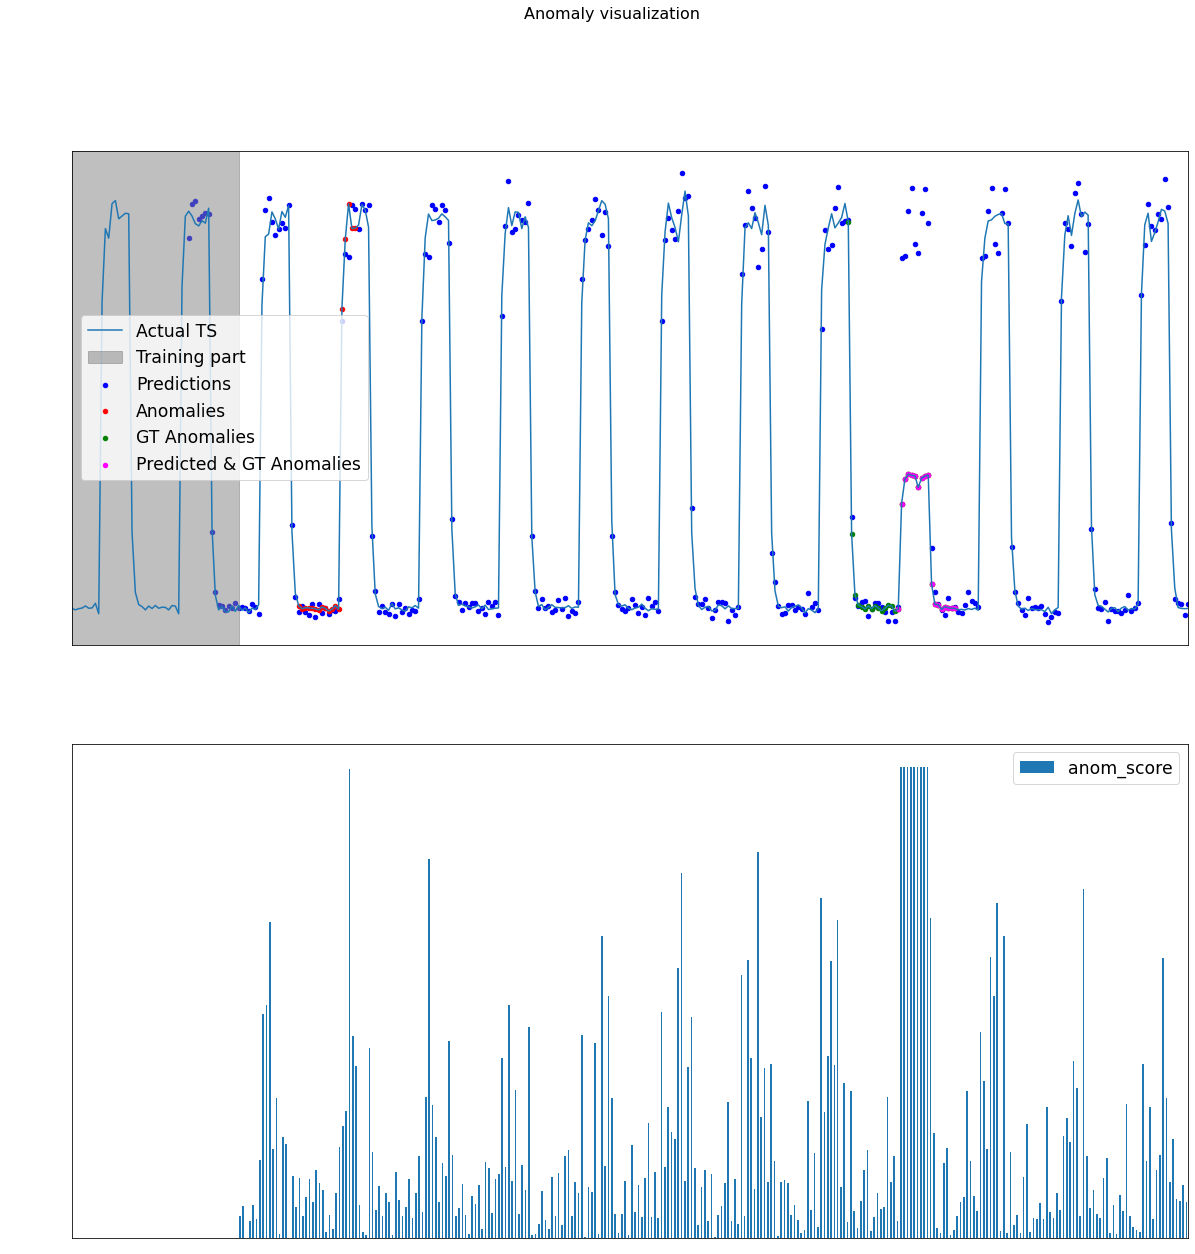

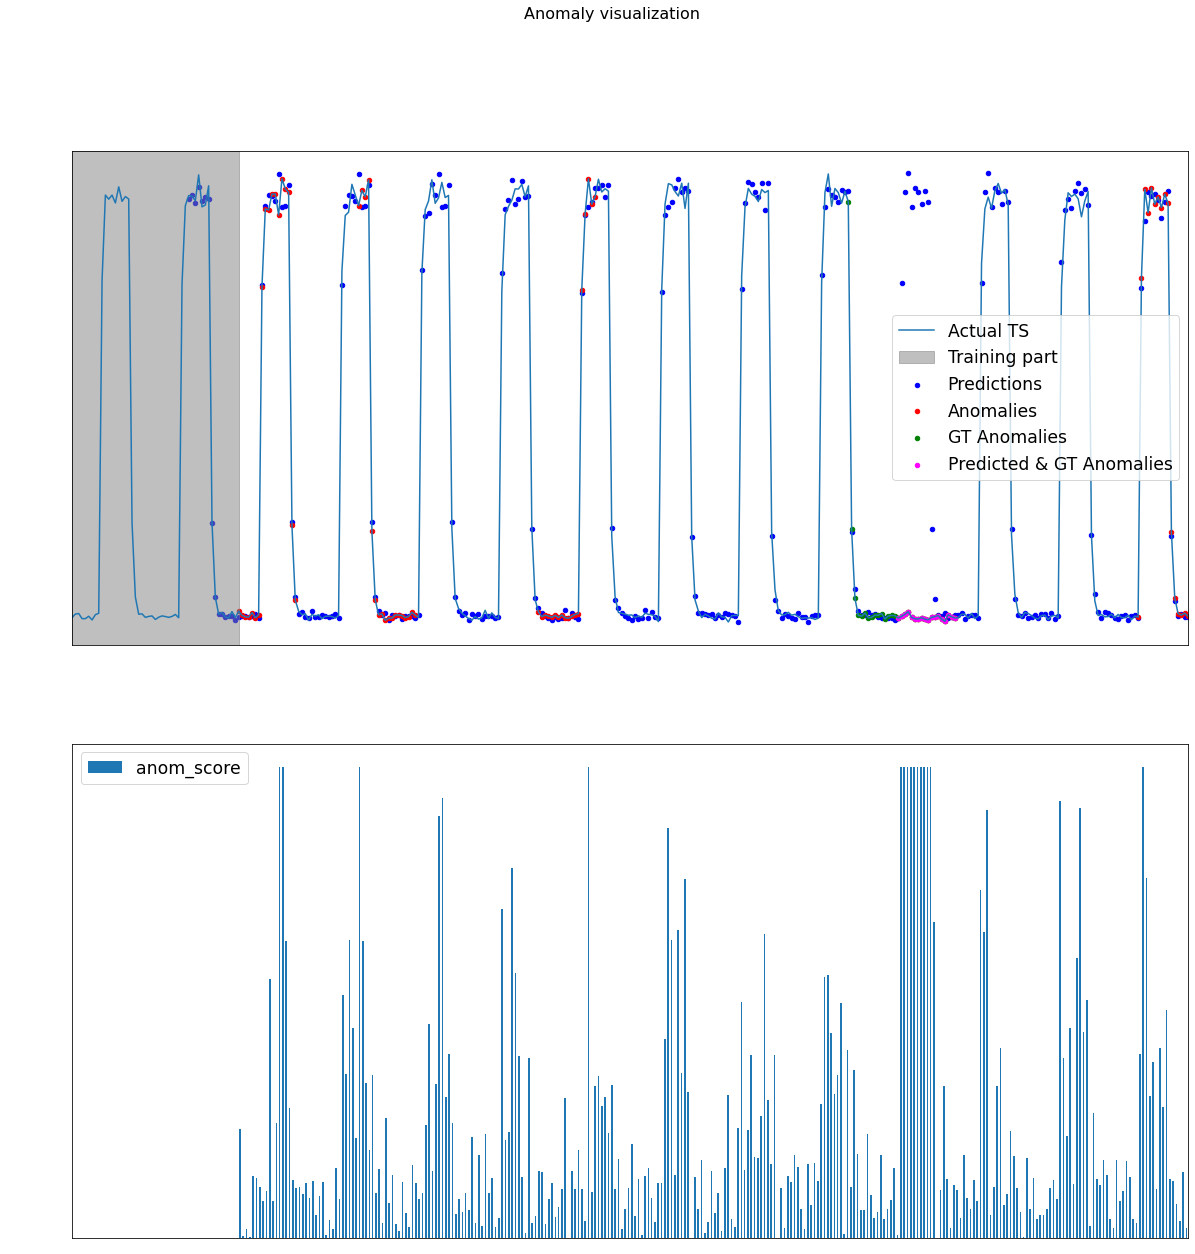

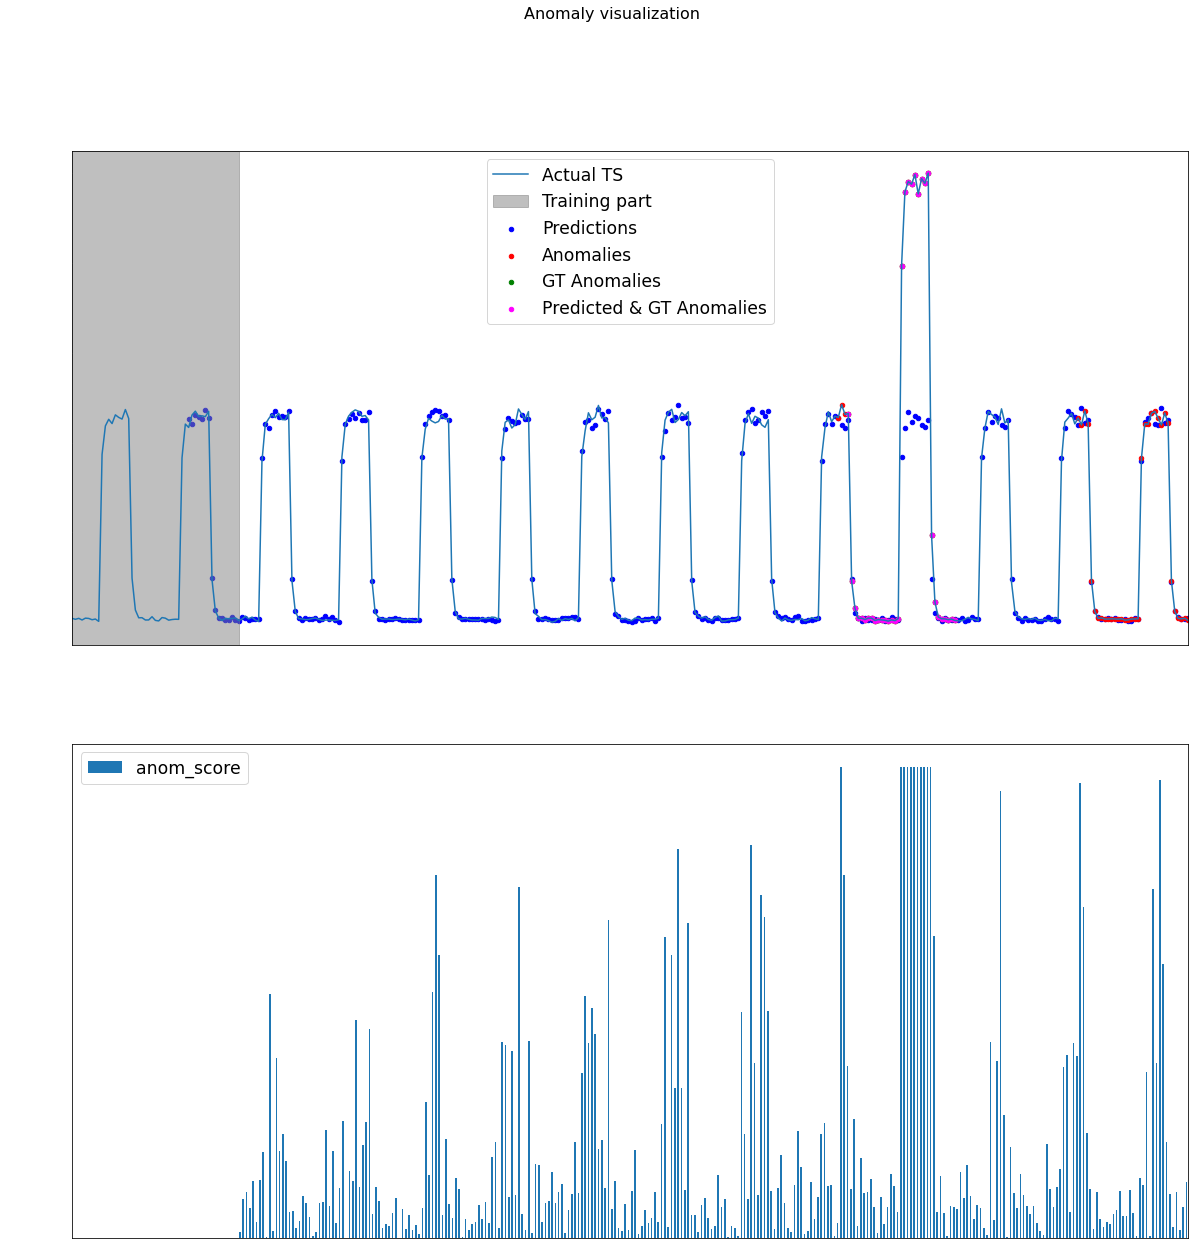

In [6]:
eval_dict: dict = {}

X_LABEL = "timestamp"
data_dir = "data/archive/"
file_dir = "artificialWithAnomaly"

with open("data/archive/combined_windows.json") as f:
    ground_true_anomalies = json.load(f)

files_to_eval = ["art_daily_flatmiddle.csv",
                 "art_daily_jumpsdown.csv",
                 "art_daily_nojump.csv",
                 "art_daily_jumpsup.csv"]

for (dirpath, dirnames, filenames) in os.walk(data_dir):
    for filename in filenames:
        if filename in files_to_eval:
            file_path = os.path.join(dirpath, filename)

            print(filename)
            eval_dict[filename] = {}

            original_df = pd.read_csv(
                file_path, parse_dates=True, index_col="timestamp"
            )

            preprocessed_df = original_df.resample("h").agg(np.mean)

            true_anomalies_ranges = ground_true_anomalies["/".join(file_path.split("/")[-2:])]
            ground_true_anomalies_df = pd.DataFrame()
            for anom_range in true_anomalies_ranges:
                ground_true_anomalies_df = ground_true_anomalies_df.append(
                    preprocessed_df.loc[anom_range[0]:anom_range[1]])
            preprocessed_df["gt_is_anomaly"] = [idx in ground_true_anomalies_df.index for idx in
                                                preprocessed_df.index.tolist()]

            scaler = MinMaxScaler(feature_range=(-1, 0))
            preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

            sarima_results = evaluate_sarima(preprocessed_df)
            eval_dict[filename][SARIMA_KEY] = sarima_results

            autoencoder_results: dict = {ACC_KEY: 0.8, PREC_KEY: 0.7, RECALL_KEY: 0.9}  # TODO implement evaluation function
            eval_dict[filename][AUTOENCODER_KEY] = autoencoder_results

In [7]:
eval_json = "eval.json"

with open(eval_json, "w") as fp:
    json.dump(eval_dict, fp)
